In [2]:
import requests
import bs4
import re
import mysql.connector
import pandas as pd
import numpy as np
from frenetic import *

# French WordNet for getting synonyms
fwn = FreNetic("/Users/mehdi.mirzapour/Dropbox/PractiKPharma/Lexicons/frenetic/wolf-1.0b4.xml")


def getCnrtl(word):

    response=requests.get("https://www.cnrtl.fr/synonymie/"+word)
    content=response.content

    parser = bs4.BeautifulSoup(content, 'html.parser')
       
    syno_format = parser.find_all("h2")
    syno_format=pd.Series(syno_format)
    syno_format=syno_format.apply(str)
    for item in syno_format:
        if ("Terme introuvable" in item) or ("Erreur" in item) :
            return ([])
     
    
    syno_format = parser.find_all("td",class_="syno_format")

    syno_format=pd.Series(syno_format)
    syno_format=syno_format.apply(str)

    syno_format=syno_format.str.extract("(\w+)</a></td>")

    syno_format.columns=["Synonym"]
    syno_format["Frequency"]=""

    img_format_1 = parser.find_all("img",alt="",height=re.compile("\d+"),src=re.compile("/images/portail/pbon.png"))
    img_format_2 = parser.find_all("img",alt="",height=re.compile("\d+"),src=re.compile("/images/portail/pboff.png"))

    img_format_1=pd.Series(img_format_1).apply(str)
    img_format_2=pd.Series(img_format_2).apply(str)

    img_format_1=img_format_1.str.extract("width=\"(\d+)\"").astype('int64')
    img_format_2=img_format_2.str.extract("width=\"(\d+)\"").astype('int64')


    syno_format["Frequency"]=img_format_1/(img_format_1+img_format_2)*100
    return list(syno_format["Synonym"])



def getSynonymo(word):

    response=requests.get("http://www.synonymo.fr/synonyme/"+word)
    content=response.content

    parser = bs4.BeautifulSoup(content, 'html.parser')
    
    
    syno_format = parser.find_all("h1")
    syno_format=pd.Series(syno_format)
    syno_format=syno_format.apply(str)
    for item in syno_format:
        if ("Aucun résultat exact n'a été trouvé" in item) or ("Aucun résultat pour" in item) or ("An Error Was Encountered" in item):
            return ([])
    

    syno_format = parser.find_all("a", class_="word",title=re.compile("\w+"))

    syno_format=pd.Series(syno_format)
    syno_format=syno_format.apply(str)

    syno_format=syno_format.str.extract(">([\w\s]+)</a>")
    syno_format.columns=["Synonym"]

    return list(syno_format["Synonym"])

def getCrisco(word):
    
    response=requests.get("http://www.crisco.unicaen.fr/des/synonymes/"+word)
    content=response.content

    parser = bs4.BeautifulSoup(content, 'html.parser')
    
    
    syno_format = parser.find_all("p")
    syno_format=pd.Series(syno_format)
    syno_format=syno_format.apply(str)
    for item in syno_format:
        if "ne possède pas de synonyme dans le DES" in item:
            return ([])
    

    syno_format = parser.find_all("a", href=re.compile("/des/synonymes/\w+"))

    syno_format=pd.Series(syno_format)
    syno_format=syno_format.apply(str)

    syno_format=syno_format.str.extract(">\xa0(\w+)\xa0")
    syno_format.columns=["Synonym"]
    syno_format=syno_format.dropna()
    syno_format=syno_format.reset_index(drop=True)

    return list(syno_format["Synonym"])


def getJDM(word):
    
    restricted_words=["\\","\'"]

    def remove_refinements(term):
        index=term.find('>')

        if index==-1:
            return term
        else:
            return (term[0:index])

    if word in restricted_words:
        return pd.DataFrame(columns = ['Synonym','Weight'])
    else:
        config = {
        'user': 'mirzapour',
        'password': 'mehdim',
        'host': 'karadoc.lirmm.fr',
        'database': '05012019_rezojdm',
        'raise_on_warnings': True
         }

        jdm_db = mysql.connector.connect(**config)

        jdm_cursor = jdm_db.cursor()
        jdm_cursor.execute(("select n2.name, e.weight from nodes n1, nodes n2,"+
                         "edges e where n1.name='"+word+"' and n1.id=e.source"+
                         " and n2.id=e.destination and e.type=5"))


        df_syn=pd.DataFrame(jdm_cursor.fetchall(),columns=['Synonym','Weight'])
        df_syn.sort_values(by=["Weight"], axis=0, ascending=False, inplace=True)

        jdm_db.close()


        df_syn=df_syn[df_syn["Weight"]>=25]
        df_syn=df_syn[~df_syn["Synonym"].str.contains("=")]
        df_syn["Synonym"]=df_syn["Synonym"].apply(remove_refinements)

        df_syn.sort_values(by=["Synonym","Weight"], axis=0, ascending=False, inplace=True)
        df_syn = df_syn.drop_duplicates(subset='Synonym', keep='first')

        df_syn.sort_values(by=["Weight"], axis=0, ascending=False, inplace=True)
        return df_syn


def getJDM_Sense_Table(word):


    def keep_refinements(term):
            index=term.find('>')

            if index==-1:
                return term
            else:
                return (term[index+1:])

    config = {
            'user': 'mirzapour',
            'password': 'mehdim',
            'host': 'karadoc.lirmm.fr',
            'database': '05012019_rezojdm',
            'raise_on_warnings': True
             }

    jdm_db = mysql.connector.connect(**config)

    jdm_cursor = jdm_db.cursor()

    jdm_cursor.execute(("select n1.name, e.weight, n2.name from nodes n1, nodes n2,"+
                             "edges e where n1.name='"+word+"' and n1.id=e.source"+
                             " and n2.id=e.destination and e.type=1"))

    df_syn=pd.DataFrame(jdm_cursor.fetchall(),columns=['Word','Sense_Weight','Sense_JDM'])
    df_syn.sort_values(by=["Sense_Weight"], axis=0, ascending=False, inplace=True)
    df_syn.reset_index(drop=True, inplace=True)


    df_syn.insert(loc=1,column="Sense_Name",value="")

    for counter,value in enumerate(df_syn["Sense_JDM"].apply(keep_refinements)):
        jdm_cursor.execute("SELECT name FROM nodes where id="+ str(value))
        fetch_result=jdm_cursor.fetchall()[0][0]
        df_syn["Sense_Name"][counter]=fetch_result


    # We can use the "df_syn" for all senses of a given word   

    table_main = pd.DataFrame(columns=["Word","Sense","Sense_Weight","Syn_Weight"])

    for item in range(0,len(df_syn)): 

        table=getJDM(list(df_syn["Sense_JDM"])[item])

        table.insert(loc=0,column="Sense",value="")
        table["Sense"]=df_syn["Sense_Name"][item]

        table.insert(loc=0,column="Word",value="")
        table["Word"]=word

        table.insert(loc=3,column="Sense_Weight",value="")
        table["Sense_Weight"]=df_syn["Sense_Weight"][item]
        table_main = pd.concat([table_main, table],sort=False)

    return (table_main)


def getJDM_Sense(word):
    jdm_sense_table=getJDM_Sense_Table(word)
    jdm_sense_table=jdm_sense_table.drop(["Syn_Weight"], axis=1)
    
    if len(jdm_sense_table)==0:
        return (np.NaN)
    else:
        return list(jdm_sense_table["Synonym"])

    
def getJDM_Sense_dic(word):    
    
    syn_list=getJDM_Sense_Table(word) 
    
    if (len(syn_list)==0):
        return (np.NaN)
    else:
        syn_list=syn_list[["Sense","Synonym"]]

        syn_dic={}
        for i in range(len(syn_list)):
            if not syn_list.iloc[i]["Sense"] in syn_dic.keys():
                syn_dic[syn_list.iloc[i]["Sense"]]=[syn_list.iloc[i]["Synonym"]]
            else:
                syn_dic[syn_list.iloc[i]["Sense"]].append(syn_list.iloc[i]["Synonym"])

        syn_index=0
        syn_dic_changed_2_num={}

        for i in syn_dic:
            syn_dic[i].insert(0,i)
            syn_dic_changed_2_num[syn_index]=syn_dic[i]
            syn_index+=1

        return(syn_dic_changed_2_num)





def getFrWordnet(str):
    
    if str=="":
        return ([])
    else:
        
        try:
            nsynsets = fwn.synsets(str)
        except:
            return ([])

        synonym_list=[]
        for i,syn in enumerate(nsynsets):
            for j,lit in enumerate(syn.literals()):
                synonym_list.append(lit.span())
    
        synonym_list = list(dict.fromkeys(synonym_list))
    
        return (synonym_list)


def getDicSyn(word):
    word=word.replace("é","%E9")
    word=word.replace("è","%E8")
    word=word.replace("î","%EE")
    word=word.replace("û","%FB")
    word=word.replace("ô","%F4")
    word=word.replace("ç","%E7")   
   
    try:
        response=requests.get("http://www.dictionnaire-synonymes.com/synonyme.php?mot="+word)
    except:
        return (np.NaN)
    print("http://www.dictionnaire-synonymes.com/synonyme.php?mot="+word)
    content=response.content

    parser = bs4.BeautifulSoup(content, 'html.parser')

    syno_format = parser.find_all("td",class_="text1")
    syno_format=pd.Series(syno_format)
    syno_format=syno_format.apply(str)
    for item in syno_format:
        if ("Veuillez vérifiez l'orthographe de votre requête" in item):
            return (np.NaN)

    syno_format = parser.find_all("a",class_=["lien2","lien3"])
    syno_format=pd.Series(syno_format)
    syno_format=syno_format.apply(str)

    syno_format=syno_format.str.extract("class=\"(\w+)\"[\s\w]+=\"\w+.\w+\?\w+=[\w%+]+\">([\w\s]+)")
    
    syno_format.dropna(inplace=True)
    syno_format.reset_index(inplace=True,drop=True)

    syn_dic={}
    syn_index=0
    for i in range(len(syno_format[0])):
        if syno_format[0][i]=="lien2":
            syn_dic[syn_index]=[syno_format[1][i]]
            syn_index+=1
        else:
            syn_dic[syn_index-1].append(syno_format[1][i])
        
    return(syn_dic)




In [ ]:
words_table=pd.read_excel(
    "/Users/mehdi.mirzapour/Dropbox/PractiKPharma/PractiKPharma_Code/excels/2_Phase3_Word_Sense_Extraction.xlsx")

for counter,value in enumerate(words_table["Word_Corrected"]):
    
    words_table["JDM_Sense"][counter]=str(getJDM_Sense_dic(value))
    words_table["JDM"][counter]=list(getJDM(value)["Synonym"])
    words_table["WordNet"][counter]=getFrWordnet(value)
    words_table["Cnrtl"][counter]=getCnrtl(value)
    words_table["Synonymo"][counter]=getSynonymo(value)
    words_table["Cisco"][counter]=getCrisco(value)
    words_table["DicSyn_Sense"][counter]=str(getDicSyn(value))

    print(counter)
    words_table.to_excel("/Users/mehdi.mirzapour/Dropbox/PractiKPharma/PractiKPharma_Code/excels/2_Phase3_Word_Sense_Extraction.xlsx")



In [6]:

words_table=pd.read_excel(
    "/Users/mehdi.mirzapour/Dropbox/PractiKPharma/PractiKPharma_Code/excels/2_Phase3_Word_Sense_Extraction.xlsx")

feature_lists=["JDM_Sense","JDM","WordNet","Cnrtl","Synonymo","Cisco","DicSyn_Sense"]

words_table=words_table[feature_lists]
words_table.fillna("[]", inplace=True)

statistic={}
for col in words_table.columns:
    statistic[col]=100*((len(words_table)-len(words_table[col][words_table[col]=="[]"]))/len(words_table))


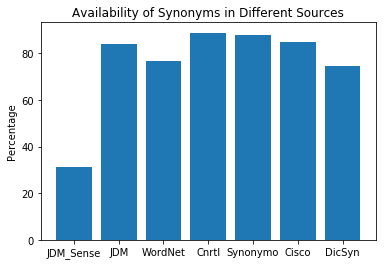

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

statistic["DicSyn"] = statistic.pop("DicSyn_Sense")
plt.bar(statistic.keys(), statistic.values())

plt.ylabel('Percentage')
plt.title('Availability of Synonyms in Different Sources')

plt.show()